# Boundary conditions on a cylindrical geometry

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt
%matplotlib inline

from tyssue.core.sheet import Sheet

from tyssue import config

from tyssue.geometry.sheet_geometry import SheetGeometry as geom
from tyssue.solvers.sheet_vertex_solver import Solver as solver


from tyssue.draw.vispy_draw import vp_view

from tyssue.draw.plt_draw import sheet_view
from tyssue.stores import load_datasets

from tyssue.topology.sheet_topology import remove_face
from tyssue.core.objects import get_opposite

In [92]:
from tyssue.dynamics.sheet_vertex_model import SheetModel as basemodel

from tyssue.dynamics.base_gradients import length_grad
from tyssue.dynamics.sheet_gradients import height_grad
from tyssue.dynamics.effectors import elastic_force, elastic_energy
from tyssue.utils.utils import _to_3d
from copy import deepcopy

class ViscousBcSheetModel(basemodel):
    
    @staticmethod
    def dimentionalize(mod_specs):
        """
        Changes the values of the input gamma and lambda parameters
        from the values of the prefered height and area.
        Computes the norm factor.
        """

        dim_mod_specs = deepcopy(mod_specs)

        Kv = dim_mod_specs['face']['vol_elasticity']
        A0 = dim_mod_specs['face']['prefered_area']
        h0 = dim_mod_specs['face']['prefered_height']
        gamma = dim_mod_specs['face']['contractility']

        dim_mod_specs['face']['contractility'] = gamma * Kv * A0 * h0**2
        dim_mod_specs['face']['prefered_vol'] = A0 * h0

        lbda = dim_mod_specs['edge']['line_tension']
        dim_mod_specs['edge']['line_tension'] = lbda * Kv * A0**1.5 * h0**2
        
        ka = dim_mod_specs['edge']['anchor_elasticity']
        dim_mod_specs['edge']['anchor_elasticity'] = ka * Kv * A0 * h0**2
        
        dim_mod_specs['settings']['grad_norm_factor'] = Kv * A0**1.5 * h0**2
        dim_mod_specs['settings']['nrj_norm_factor'] = Kv * (A0*h0)**2

        return dim_mod_specs
    
    @staticmethod
    def compute_energy(sheet, full_output=False):
        nrj_norm_factor = sheet.specs['settings']['nrj_norm_factor']

        E_r = sheet.vert_df.eval('height * radial_tension * is_active')
        E_a = sheet.edge_df.eval('anchor_elasticity * length**2 * is_anchor / 2')
        
        if full_output:
            E_t, E_c, E_v = basemodel.compute_energy(sheet, full_output=True)
            return E_t, E_c, E_v, E_r / nrj_norm_factor, E_a / nrj_norm_factor
        else:
            E_base = basemodel.compute_energy(sheet, full_output=False)
            return E_base + (E_r.sum() + E_a.sum()) / nrj_norm_factor

    @classmethod
    def compute_gradient(cls, sheet, components=False):

        nrj_norm_factor = sheet.specs['settings']['nrj_norm_factor']
        grad_lij = length_grad(sheet)

        grad_t = cls.tension_grad(sheet, grad_lij)
        grad_c = cls.contractile_grad(sheet, grad_lij)
        grad_v_srce, grad_v_trgt = cls.elastic_grad(sheet)
        grad_r = (_to_3d(sheet.vert_df['radial_tension']) *
                    height_grad(sheet))
        grad_a = cls.anchor_grad(sheet, grad_lij)
        
        if components:
            return grad_t, grad_c, grad_a, grad_v_srce, grad_v_trgt, grad_r

        grad_i = (
            (sheet.sum_srce(grad_t) - sheet.sum_trgt(grad_t))/2 +
            sheet.sum_srce(grad_c) - sheet.sum_trgt(grad_c) +
            sheet.sum_srce(grad_v_srce) + sheet.sum_trgt(grad_v_trgt) +
            sheet.sum_srce(grad_a) + grad_r
            ) * _to_3d(sheet.vert_df.is_active) / nrj_norm_factor
        
        return grad_i
        
    @staticmethod
    def relax_anchors(sheet):
        '''reset the anchor positions of the border vertices
        to the positions of said vertices.

        '''
        anchors = ['ax', 'ay', 'az']
        at_border = sheet.vert_df[sheet.vert_df['at_border']==1].index
        sheet.vert_df.loc[at_border,
                          anchors] = sheet.vert_df.loc[at_border,
                                                       sheet.coords]

    @staticmethod
    def anchor_grad(sheet, grad_lij):
        
        ka = sheet.edge_df.eval('anchor_elasticity * length * is_anchor')
        return grad_lij * _to_3d(ka)

bc_model = ViscousBcSheetModel       

In [109]:
ls

Apoptosis.ipynb            Cell Division.ipynb        small_hexagonal.hf5
Boundary conditions.ipynb  Energy minimization.ipynb  Type 1 transition.ipynb


In [105]:
# h5store = 'before_apoptosis.hf5'
h5store = 'small_hexagonal.hf5'

datasets = load_datasets(h5store,
                         data_names=['face', 'vert', 'edge'])
datasets['edge'] = datasets['edge'][['srce', 'trgt', 'face']]
datasets['face'] = datasets['face'][['x', 'y', 'z', 'is_alive']]
datasets['vert'] = datasets['vert'][['x', 'y', 'z']]

specs = config.geometry.sheet_spec()
sheet = Sheet('emin', datasets, specs)
geom.update_all(sheet)


bc_specs = {
    'face': {
        'at_border': 0,
    },
    'edge': {
        'at_border': 0,
        'is_anchor': 0,
        'opposite': -1,
    },
    'vert': {
        'at_border': 0,
        'is_anchor': 0,
    }
}

sheet.update_specs(bc_specs)

live_edges = sheet.upcast_face(sheet.face_df.is_alive)

# ## Boundary conditions
sheet.vert_df.is_active = 1

# dead_src = set(sheet.edge_df[live_edges==0].srce)
# sheet.vert_df.loc[dead_src, 'is_active'] = 0

# ## Remove dead cells at boundary
boundary_cells = sheet.face_df[sheet.face_df.is_alive==0].index
for cell in boundary_cells:
    remove_face(sheet, cell)
geom.update_all(sheet)


def create_anchors(sheet):
    '''Adds an edge linked to every vertices at the boundary and create anchor vertices'''
    
    # ## Edges with no opposites denote the boundary

    free_edge = sheet.edge_df[sheet.edge_df['opposite'] == -1]
    free_vert = sheet.vert_df.loc[free_edge['srce']]
    free_face = sheet.face_df.loc[free_edge['face']]

    sheet.edge_df.loc[free_edge.index, 'at_border'] = 1
    sheet.vert_df.loc[free_vert.index, 'at_border'] = 1
    sheet.face_df.loc[free_face.index, 'at_border'] = 1

    # ## Make a copy of the boundary vertices
    anchor_vert_df = free_vert.reset_index()
    anchor_vert_df['z'] = anchor_vert_df['z'] * 1.5
    anchor_vert_df.index = anchor_vert_df.index+sheet.Nv
    anchor_vert_df['is_anchor'] = 1
    anchor_vert_df['at_border'] = 0
    anchor_vert_df['is_active'] = 0

    sheet.vert_df = pd.concat([sheet.vert_df,
                               anchor_vert_df])
    anchor_edge_df = pd.DataFrame(
        index=np.arange(sheet.Ne, sheet.Ne + free_vert.shape[0]),
        columns=sheet.edge_df.columns
        )

    anchor_edge_df['srce'] = free_vert.index
    anchor_edge_df['trgt'] = anchor_vert_df.index
    anchor_edge_df['line_tension'] = 0
    anchor_edge_df['is_anchor'] = 1
    anchor_edge_df['face'] = 0
    anchor_edge_df['at_border'] = 0

    sheet.edge_df = pd.concat([sheet.edge_df,
                               anchor_edge_df])
    sheet.reset_topo()

geom.update_all(sheet)

In [110]:
anchor_elasticity = 100.

nondim_specs = config.dynamics.quasistatic_sheet_spec()
nondim_specs['edge']['anchor_elasticity'] = anchor_elasticity
dim_model_specs = bc_model.dimentionalize(nondim_specs)
sheet.update_specs(dim_model_specs, reset=True)

In [108]:
vp_view(sheet)

In [113]:

min_settings = {
    'minimize': {
        'options': {
            'disp': False,
            'ftol': 1e-6,    
            'gtol': 1e-8},
        }
    }

res = solver.find_energy_min(sheet, geom, 
                             bc_model, **min_settings)
print(res['success'])

True


In [103]:
from tyssue.draw import plt_draw

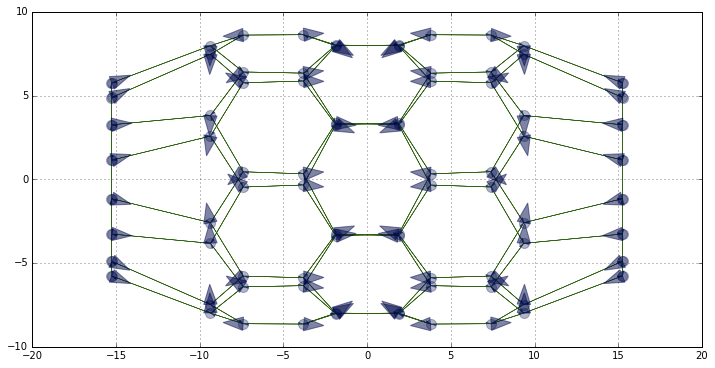

In [117]:

fig, ax = plt_draw.plot_forces(sheet, geom, bc_model, coords=['z', 'x'], scaling=10)
fig.set_size_inches(12, 12)

In [79]:
bc_model.compute_energy(sheet)

31.6009510040866

In [10]:
vp_view(sheet)

/home/guillaume/anaconda3/envs/py35/lib/python3.5/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)


In [9]:
anchor_edges

,dz,length,dx,dy,srce,trgt,face,old_jv0,old_jv1,old_cell,...,nx,ny,sub_area,sub_vol,line_tension,is_alive,opposite,is_anchor,anchor_elasticity,at_border
edge,,,,,,,,,,,,,,,,,,,,,
224,-5.091027,5.091027,0.0,0.0,78,80,0,NaN,NaN,NaN,...,5.832972,29.324330,14.949414,130.82039,0.0,NaN,-1.0,1,NaN,NaN
225,5.091027,5.091027,0.0,0.0,65,81,0,NaN,NaN,NaN,...,5.832972,-29.324330,14.949414,130.82039,0.0,NaN,-1.0,1,NaN,NaN
226,-5.091027,5.091027,0.0,0.0,64,82,0,NaN,NaN,NaN,...,-16.610898,24.859966,14.949414,130.82039,0.0,NaN,-1.0,1,NaN,NaN
227,5.091027,5.091027,0.0,0.0,67,83,0,NaN,NaN,NaN,...,24.859966,-16.610898,14.949414,130.82039,0.0,NaN,-1.0,1,NaN,NaN
228,-5.091027,5.091027,0.0,0.0,66,84,0,NaN,NaN,NaN,...,-29.324330,5.832972,14.949414,130.82039,0.0,NaN,-1.0,1,NaN,NaN
229,5.091027,5.091027,0.0,0.0,69,85,0,NaN,NaN,NaN,...,29.324330,5.832972,14.949414,130.82039,0.0,NaN,-1.0,1,NaN,NaN
230,-5.091027,5.091027,0.0,0.0,68,86,0,NaN,NaN,NaN,...,-24.859966,-16.610898,14.949414,130.82039,0.0,NaN,-1.0,1,NaN,NaN
231,5.091027,5.091027,0.0,0.0,71,87,0,NaN,NaN,NaN,...,16.610898,24.859966,14.949414,130.82039,0.0,NaN,-1.0,1,NaN,NaN
232,-5.091027,5.091027,0.0,0.0,70,88,0,NaN,NaN,NaN,...,-5.832972,-29.324330,14.949414,130.82039,0.0,NaN,-1.0,1,NaN,NaN


In [43]:
sheet.vert_df.tail()

,at_border,basal_shift,height,is_active,is_anchor,old_idx,radial_tension,rho,vert,x,y,z
vert,,,,,,,,,,,,
91,0,-2.878023,8.750871,0.0,1,132.5,0.0,5.872848,75.0,-3.262780,-4.883095,15.27308
92,0,-2.878023,8.750871,0.0,1,128.5,0.0,5.872848,74.0,-1.145736,-5.760003,-15.27308
93,0,-2.878023,8.750871,0.0,1,144.5,0.0,5.872848,77.0,1.145736,-5.760003,15.27308
94,0,-2.878023,8.750871,0.0,1,140.5,0.0,5.872848,76.0,3.262780,-4.883095,-15.27308
95,0,-2.878023,8.750871,0.0,1,113.5,0.0,5.872848,79.0,4.883095,-3.262780,15.27308


In [44]:

sheet.vert_df.loc[anchor_edges.trgt]

,at_border,basal_shift,height,is_active,is_anchor,old_idx,radial_tension,rho,vert,x,y,z
vert,,,,,,,,,,,,
80,0,-2.878023,8.750871,0.0,1,57.5,0.0,5.872848,78.0,5.760003,-1.145736,-15.27308
81,0,-2.878023,8.750871,0.0,1,77.5,0.0,5.872848,65.0,5.760003,1.145736,15.27308
82,0,-2.878023,8.750871,0.0,1,57.5,0.0,5.872848,64.0,4.883095,3.262780,-15.27308
83,0,-2.878023,8.750871,0.0,1,84.5,0.0,5.872848,67.0,3.262780,4.883095,15.27308
84,0,-2.878023,8.750871,0.0,1,80.5,0.0,5.872848,66.0,1.145736,5.760003,-15.27308
85,0,-2.878023,8.750871,0.0,1,96.5,0.0,5.872848,69.0,-1.145736,5.760003,15.27308
86,0,-2.878023,8.750871,0.0,1,92.5,0.0,5.872848,68.0,-3.262780,4.883095,-15.27308
87,0,-2.878023,8.750871,0.0,1,108.5,0.0,5.872848,71.0,-4.883095,3.262780,15.27308
88,0,-2.878023,8.750871,0.0,1,104.5,0.0,5.872848,70.0,-5.760003,1.145736,-15.27308
